<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [ ]:
#@title Current Date
Today = '' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20197772" #@param {type:"string"}
Student_full_name = "Barry Lawton" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [21]:
# Setting a seed:
np.random.seed(123)
# This is create reproducible results, however can be changed or removed

## Dataset

### Loading the MNIST dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgRKTjybldltWHGfYFGDSpqTuGikyaxr_Yzh0sTZC6Qs_wgsIxBCRQ
Mounted at /content/drive


The MNIST dataset has been uploaded to google drive, Colab conviently allows this to be mounted within the notebook for easy access.  

In [7]:
# Path, copy the path from your Drive

Path = '/content/drive/My Drive/Data/'
# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print("Training dataset shape : ",X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print("Test dataset shape : ",X_test.shape)

Training dataset shape :  (60000, 784)
Test dataset shape :  (10000, 784)


The training data consists of 60,000 examples, while the test data has 10,000 examples. Each example contains 784 pixels, which forms a 28 * 28 pixel image of a handwritten digit.

In [10]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


As part of the preprocessing the dataset is normalized. Each pixel is denoted by a value between 0 and 255, where 0 corresponds to white and 255 corresponds to black.  
To normalise, each value is divided by 255, so the pixels will now range between 0 and 1.

### Description of Data:

In [9]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

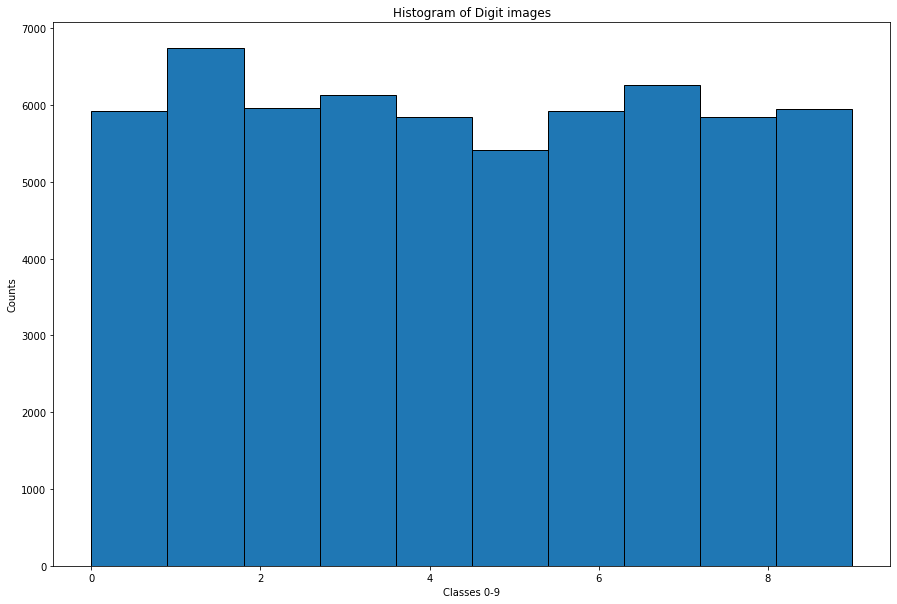

In [17]:
fig, ax = plt.subplots(figsize=(15,10) )
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes, edgecolor = 'black')
ax.set_xlabel('Classes 0-9')
ax.set_ylabel('Counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

The histogram of the Digit images shows a similar frequency between different classes.     
The digit 1 appears more frequently than the other classes, while 5 is less frequent that the other examples. Aside from these classes, the remaining classes are reasonably evenly distributed.

## Downsampling

The dataset will now be downsampled, 3 classes will be randomly selcted.      
Note np.random.seed() function above will determine the results achieved and needs to be updated if different classes are desired.

### Randomly selecting 3 of the 10 Digit Classes

In [22]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes :
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

After randomly selecting 3 classes, then 500 instances are selected from each class, this not only downsamples the data but will also balance the data.
As noted previously when looking at all the training data there was a slight inbalance between classes. 

In [23]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 500

inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

New Classes Distribution

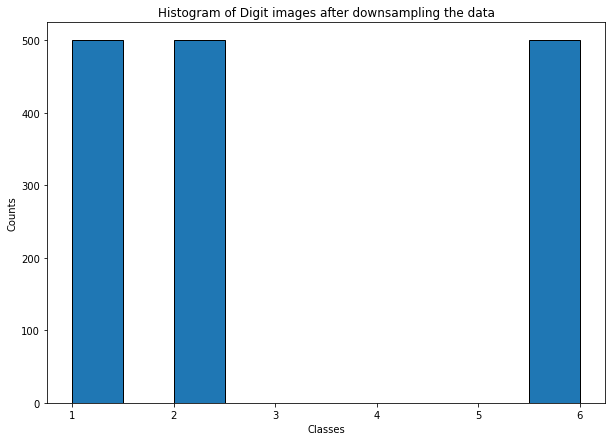

In [35]:
# new histogram of the data after downsampling
fig, ax = plt.subplots(figsize = (10,7))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train,edgecolor= "black")
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title(r'Histogram of Digit images after downsampling the data')
plt.show()

Next a fucntion to plot a sample of the data is created. This will plot a user defined amount of images.

In [36]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

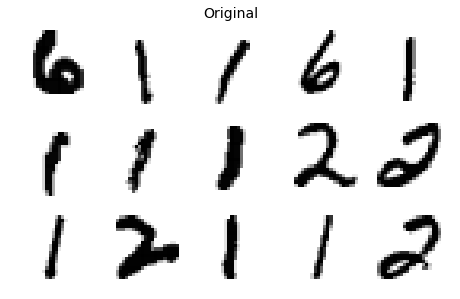

In [38]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.random.choice(len(X_train), 15,replace = None)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=5)
plt.title("Original", fontsize=14)
plt.show()

This selection of digits look quite distintive and well defined. It should be possible to make a ML model which will accurately classify their class.

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [39]:
### Split the dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [42]:
# print shape of your validation and training set
print(" The size of the training data : ", X_train.shape)
print(" The size of the validation data :",X_val.shape)

 The size of the training data :  (1200, 784)
 The size of the validation data : (300, 784)


### General-Recipe ML

The first model created will be a general-recipe multinomial logistic classifier to predict the class any image belongs to.
This is created using SKLearn LogisticRegression() function.

In [43]:
# model
model_log = LogisticRegression(random_state = 0, max_iter = 2000, C = 100, solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.9633333333333334

In [44]:
np.sort(prob_classmax)

array([0.39409616, 0.51703571, 0.59686785, 0.62928968, 0.72583031,
       0.82924202, 0.88561016, 0.8867972 , 0.89489589, 0.94089598,
       0.9479797 , 0.95248389, 0.95657066, 0.97076276, 0.97441661,
       0.97485455, 0.9752814 , 0.97563668, 0.97994533, 0.98291757,
       0.98597388, 0.98666844, 0.98758472, 0.9902986 , 0.99361963,
       0.99515941, 0.9953285 , 0.99585479, 0.99621615, 0.99661621,
       0.99753731, 0.99828815, 0.99854504, 0.99862629, 0.99872612,
       0.99902954, 0.99918203, 0.99929637, 0.99933048, 0.99957252,
       0.99969625, 0.99970868, 0.99972766, 0.99972809, 0.99975593,
       0.99976099, 0.99976307, 0.9997646 , 0.99979821, 0.99980056,
       0.99982151, 0.99982658, 0.99982803, 0.99984959, 0.99985861,
       0.99987887, 0.99988129, 0.99988709, 0.99990242, 0.99990463,
       0.99991729, 0.99991849, 0.99992029, 0.99992711, 0.99992862,
       0.9999364 , 0.99993765, 0.99993906, 0.9999432 , 0.9999445 ,
       0.99994461, 0.99994496, 0.99994771, 0.99994952, 0.99995

In [45]:
# Probability of general recipe logistics regression in the wrong instances
prob_classmax[y_pred_log!=y_val]

array([0.39409616, 0.97076276, 0.99585479, 0.99828815, 0.72583031,
       0.51703571, 0.99872612, 0.88561016, 0.99933048, 0.62928968,
       0.95657066])

In [46]:
np.array(y_pred_log)

array([1., 1., 6., 1., 6., 6., 2., 6., 1., 6., 6., 6., 6., 1., 2., 2., 6.,
       6., 1., 6., 1., 2., 1., 1., 6., 2., 2., 6., 2., 6., 6., 1., 6., 2.,
       6., 6., 1., 2., 2., 1., 6., 6., 6., 1., 1., 2., 6., 2., 2., 6., 2.,
       6., 2., 6., 2., 6., 2., 2., 6., 2., 1., 1., 6., 1., 2., 2., 2., 6.,
       1., 6., 1., 1., 2., 6., 1., 2., 2., 1., 1., 6., 6., 1., 1., 1., 2.,
       1., 6., 1., 6., 1., 2., 2., 1., 1., 6., 6., 2., 1., 1., 2., 6., 6.,
       1., 2., 6., 2., 1., 1., 2., 6., 1., 1., 1., 1., 6., 1., 1., 6., 2.,
       2., 1., 2., 1., 2., 1., 2., 1., 1., 6., 2., 6., 2., 1., 6., 2., 1.,
       1., 1., 6., 2., 1., 2., 2., 2., 1., 1., 2., 1., 6., 1., 1., 6., 1.,
       1., 2., 2., 6., 1., 2., 2., 6., 2., 1., 6., 6., 2., 6., 6., 1., 1.,
       1., 2., 6., 1., 2., 1., 1., 2., 6., 2., 1., 1., 2., 1., 2., 1., 2.,
       1., 1., 2., 1., 6., 6., 1., 6., 1., 6., 1., 1., 1., 1., 1., 2., 1.,
       2., 1., 1., 1., 2., 2., 6., 2., 1., 6., 6., 1., 6., 2., 2., 6., 2.,
       1., 2., 2., 2., 1.

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

In [ ]:
import sklearn.preprocessing
## We use LabelBinarizer to transfer classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


In [ ]:
with multi_logistic:
  approx = pm.fit(3000, method = 'advi')

Finished [100%]: Average Loss = 8,603


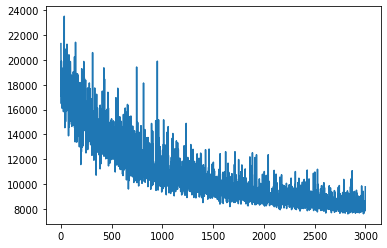

In [ ]:
plt.plot(approx.hist)
plt.show()

In [ ]:
dd = 300
posterior = approx.sample(draws = dd)

Test image #243
Posterior sample #197
True Class 8.0
Classes: [3, 6, 8]
Estimated prob =  [0.00000002 0.         0.99999998]


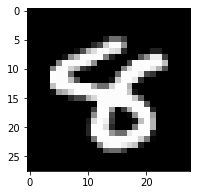

In [ ]:
## Now lets test the model, by validating it against an image in the test set

from scipy.special import softmax

# select an image in the test set
#i = 10 
i = random.randint(0,dd)

# select a sample from the posterior
#s = 100
s = random.randint(0,dd)

beta = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:] ])
alpha = np.hstack([[0] , posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(3,3))
plt.imshow(image, cmap = 'gray')
np.set_printoptions(suppress= True)

print("Test image #" + str(i) )
print("Posterior sample #" + str(s) )
print("True Class", y_val[i] )
print("Classes: " + str(classes) )
print("Estimated prob = " , softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:] )

In [ ]:
# Bayesian Prediction
# calculate the class that has the highest posterior probability

y_pred_Bayes = []

for i in range(X_val.shape[0]):
  val = np.zeros((1,len(classes)))

  for s in range(posterior['beta'].shape[0]):
    beta = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:]])
    alpha = np.hstack([[0], posterior['alpha'][s,:] ])
    val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
  
  mean_probability = val/posterior['beta'].shape[0]
  y_pred_Bayes.append( np.argmax(mean_probability))

In [ ]:
print(y_pred_Bayes)

[0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 2, 0, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0]


In [ ]:
print("Accuracy = ", accuracy_score(np.array(classes)[y_pred_Bayes], y_val))

Accuracy =  0.88


## Detecting difficult and easy instances to predict

In [ ]:
len(X_val)
#posterior['alpha'].shape[0]
#posterior['alpha']

300

In [ ]:
y_predB = []

for i in range(X_val.shape[0]):
  val = []
   
  for s in range(posterior['beta'].shape[0]):
    beta = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:] ])
    alpha = np.hstack([ [0], posterior['alpha'][s,:] ])
    val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha ])))[0,:])

  # mean probability
  valmean = np.mean(val, axis = 0)
  # class with maximum mean probabilty
  classmax = np.argmax(valmean)

  #ranks
  ranks = np.array(val.copy())
  ranks = ranks *0 #init
  column_max  = np.argmax(np.array(val), axis = 1)
  ranks[np.arange(0, len(column_max)), coloumn_max] = 1

  y_predB.append( [classmax , valmean[classmax], np.std(ranks, axis = 0)[classmax]])

y_predB = np.array(y_predB)  



In [ ]:
# The prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.67777662, 0.46774875],
       [0.        , 0.89711128, 0.46774875],
       [2.        , 0.96538539, 0.32496154],
       [0.        , 0.98735862, 0.46774875],
       [2.        , 0.83280472, 0.32496154],
       [2.        , 0.81782089, 0.32496154],
       [1.        , 0.90396266, 0.40247843],
       [0.        , 0.84676636, 0.46774875],
       [0.        , 0.8169003 , 0.46774875],
       [2.        , 0.83454549, 0.32496154]])

In [ ]:
# sorting the prediction array in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.67777662, 0.46774875],
       [0.        , 0.72310189, 0.46774875],
       [0.        , 0.72197904, 0.46774875],
       [0.        , 0.76335342, 0.46774875],
       [0.        , 0.99463636, 0.46774875],
       [0.        , 0.97793255, 0.46774875],
       [0.        , 0.98310967, 0.46774875],
       [0.        , 0.90799258, 0.46774875],
       [0.        , 0.5896935 , 0.46774875],
       [0.        , 0.64531841, 0.46774875]])

In [ ]:
# The Probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([0.95537828, 0.99989538, 0.99986447, 0.95639031, 0.9998095 ,
       0.99975773, 0.99997023, 0.99794497, 0.82303785, 0.96396183,
       0.99287251, 0.97392653])

In [ ]:
y_predB[y_pred_log != y_val,:]

array([[0.        , 0.9838679 , 0.46774875],
       [2.        , 0.8405685 , 0.32496154],
       [2.        , 0.43311246, 0.32496154],
       [0.        , 0.96705297, 0.46774875],
       [2.        , 0.9082194 , 0.32496154],
       [0.        , 0.92563627, 0.46774875],
       [1.        , 0.67060227, 0.40247843],
       [2.        , 0.92678172, 0.32496154],
       [2.        , 0.76708107, 0.32496154],
       [0.        , 0.55763019, 0.46774875],
       [0.        , 0.84149637, 0.46774875],
       [1.        , 0.7085904 , 0.40247843]])

In [ ]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("The accuracy in the easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("The accuracy in the difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))


The accuracy in the easy instances = 0.95
The accuracy in the difficult instances = 0.95


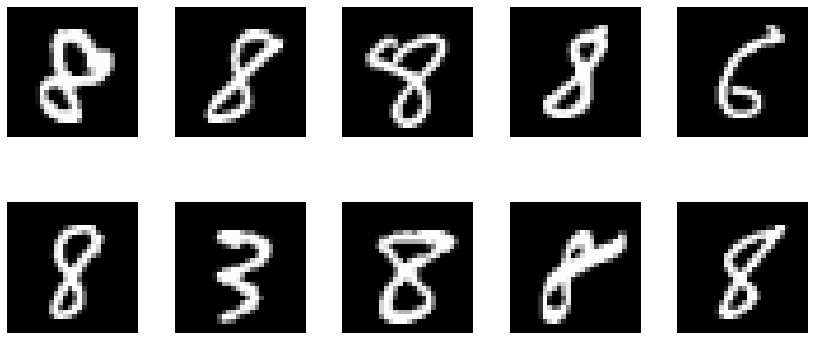

In [ ]:
# Lets show 10 random examples of easy images
fig, axs = plt.subplots(2,5, figsize=(15,6))
fig.subplots_adjust(hspace = 0.5, wspace= 0.005)
axs = axs.ravel()

for i in range(10):
  index = easy[i]
  image = X_val[index,:].reshape(28,28)
  axs[i].axis('off')
  axs[i].imshow(image, cmap ="gray")

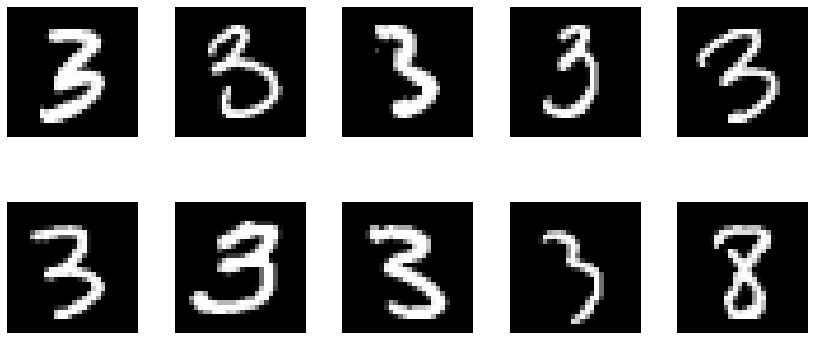

In [ ]:
# Now lets show 10 random examples of difficult images
fig, axs = plt.subplots(2,5, figsize=(15,6))
fig.subplots_adjust(hspace = 0.5, wspace= 0.005)
axs = axs.ravel()

for i in range(10):
  index = difficult[i]
  image = X_val[index,:].reshape(28,28)
  axs[i].axis('off')
  axs[i].imshow(image, cmap ="Greys_r")

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.